In [1]:
#filename = "D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/OrcaAnalysis/split_orca_output/splitted_orca_job1.out"
filename = 'C:/Users/ettor/Desktop/NONCOV/scratch/OrcaAnalysis/split_orca_output/splitted_orca_job1.out'
n_nuclei = 20

In [ ]:
import pandas as pd
import re

def extract_j_coupling(n_nuclei, filename):
    
    column_labels = []
    
    data = []
    
    start_reading = False
    
    row_data = []
    
    rows_to_read = 0
    
    with open(filename, 'r') as file:
        
        for line in file:

            if 'SUMMARY OF ISOTROPIC COUPLING CONSTANTS (Hz)' in line:
                start_reading = True
                continue

            if 'Maximum memory used throughout the entire EPRNMR-calculation:' in line:
                break
            
            if start_reading:

                if not column_labels and re.search(r'\d+ [A-Z]', line):
                    column_labels = re.findall(r'\d+ [A-Z]', line)
                    rows_to_read = n_nuclei
                    print(f"Column labels extracted: {column_labels}")
                    continue
                
                # Accumulate data if we are reading rows
                if rows_to_read > 0:
                    line_parts = line.split()
                    
                    if not line_parts:
                        continue
                    
                    # Detect if this line contains row header and values
                    if len(line_parts) > 2:
                        row_nucleus = line_parts[0] + ' ' + line_parts[1]  # Y-axis nucleus
                        values = line_parts[2:]
                        
                        # Combine current row data with new values
                        if row_data:
                            row_data[1].extend(values)
                        else:
                            row_data = [row_nucleus, values]

                        # Check if we have a complete row
                        if len(row_data[1]) >= len(column_labels):
                            # Extract complete row data
                            row_nucleus = row_data[0]
                            values = row_data[1][:len(column_labels)]
                            
                            # Store row data
                            data.append([row_nucleus] + [float(value) for value in values])
                            
                            # Reset row_data for the next row
                            row_data = []
                            rows_to_read -= 1
                            if rows_to_read == 0:
                                continue
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['Nucleus'] + column_labels)
    df.set_index('Nucleus', inplace=True)

    return df

# Example usage:
df = extract_j_coupling(n_nuclei,filename)

# Print the DataFrame
df

In [3]:
list_molecules = OrcaAnalysis().extract_molecule_names(filename)
list_molecules

['displaced_structure_1.xyz',
 'displaced_structure_2.xyz',
 'displaced_structure_3.xyz',
 'displaced_structure_4.xyz',
 'displaced_structure_5.xyz',
 'displaced_structure_6.xyz',
 'displaced_structure_7.xyz',
 'displaced_structure_8.xyz',
 'displaced_structure_9.xyz',
 'displaced_structure_10.xyz',
 'displaced_structure_11.xyz',
 'displaced_structure_12.xyz',
 'displaced_structure_13.xyz',
 'displaced_structure_14.xyz',
 'displaced_structure_15.xyz',
 'displaced_structure_16.xyz',
 'displaced_structure_17.xyz',
 'displaced_structure_18.xyz',
 'displaced_structure_19.xyz']

In [4]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [6]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

mol_dir = os.path.join(scratch_dir, 'test_structs/benzene_H2O.xyz')
print(f'Current molecule directory is: {mol_dir}')
mol_dir = OrcaAnalysis().convert_path(mol_dir)

Current work directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\results
Current scratch directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch
Current molecule directory is: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch\test_structs/benzene_H2O.xyz
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz


In [8]:
import os
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

nucprop = os.path.join(datasets_dir, 'nuc_prop_nmr_observables.csv')
nucprop_df = pd.read_csv(nucprop)

pw_nucprop = os.path.join(datasets_dir, 'pairwise_nuc_prop_nmr_observables.csv')
pw_nucprop_df = pd.read_csv(pw_nucprop)

In [5]:
n_jobs = 1

In [6]:
# --- Extract the CSA tensor components for each nucleus at each distance iteration --- #

# Initialize variables for shielding tensor components
S_dia = []
S_para = []
S_tot = []
nuclear_identities = []
mayer_bo = []
nuc_coords = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1): # split files = number of jobs
        
    blockPrint()
    
    # Path to the splitted outputs from the .out MPI8 file
    orca_splitted_output = OrcaAnalysis().convert_path(os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output', f'splitted_orca_job{job_number}.out'))

    # Extract CSA data
    shielding_dia, shielding_para, shielding_tot, nucleus_info = OrcaAnalysis().extract_tensor_data(orca_splitted_output)

    # Here include j coupling extraction
    #-------------
    
    # Extract bond orders
    bond_orders = OrcaAnalysis().extract_mayer_bond_order(orca_splitted_output)
    
    # Print the bond orders and their interacting nuclei
    for nucleus, bonds in bond_orders.items():
        print(f"{nucleus}:")
        for interacting_nucleus, bond_order in bonds:
            print(f"  Bond with {interacting_nucleus}: {bond_order}")
    
    enablePrint()
    
    coords = OrcaAnalysis().extract_xyz_coords(orca_splitted_output)
    
    # Append shielding tensor matrices (non-diagonalized) - all nuclei for each job iteration
    S_dia.append(shielding_dia)
    S_para.append(shielding_para)
    S_tot.append(shielding_tot)
    nuclear_identities.append(nucleus_info)
    
    # Append bond orders
    mayer_bo.append(bond_orders)
    
    # Append coordinates
    nuc_coords.append(coords)

In [11]:
# Get all the data that are not pairwise
data = []

# Loop through the number of jobs and get each molecule, each job has a different one
for job_number in range(n_jobs):
    molecule_name = list_molecules[job_number]
    
    # Process each job for S_tot
    shielding_dict = S_tot[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            shielding_tensor, s_iso, diagonal_mehring, diagonal_haberlen, eigenvals, eigenvecs, symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            sigma_11 = diagonal_mehring[0][0]
            sigma_22 = diagonal_mehring[1][1]
            sigma_33 = diagonal_mehring[2][2]
            
            # Extract coordinates and identities for the current nucleus
            nuc_id = nuclear_identities[job_number][nucleus_index]
            
            # Handle different structures of nuc_coords
            coords = nuc_coords[job_number][nucleus_index]
            if len(coords) >= 3:
                x_coord = coords[1]
                y_coord = coords[2]
                z_coord = coords[3]
            else:
                x_coord = y_coord = z_coord = None  

            # Collect the data for this nucleus
            row_data = {
                'Molecule': molecule_name,
                'Atom': nuc_id,
                'x_coord': x_coord,
                'y_coord': y_coord,
                'z_coord': z_coord,
                'sigma_iso': s_iso,
                'sigma_11': sigma_11,
                'sigma_22': sigma_22,
                'sigma_33': sigma_33,
                'dia_sigma_11': None,  
                'dia_sigma_22': None,
                'dia_sigma_33': None,
                'para_sigma_11': None,  
                'para_sigma_22': None,
                'para_sigma_33': None,
                'nmr_functional': None,
                'nmr_basis_set': None
            }
            data.append(row_data)

# After collecting data from S_tot, update with data from S_dia
for job_number in range(n_jobs):
    shielding_dict = S_dia[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            dia_shielding_tensor, dia_s_iso, dia_diagonal_mehring, dia_diagonal_haberlen, dia_eigenvals, dia_eigenvecs, dia_symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            dia_sigma_11 = dia_diagonal_mehring[0][0]
            dia_sigma_22 = dia_diagonal_mehring[1][1]
            dia_sigma_33 = dia_diagonal_mehring[2][2]

            # Update the existing row_data with dia_sigma values
            for row in data:
                if row['Molecule'] == molecule_name and row['Atom'] == nucleus_key:
                    row.update({
                        'dia_sigma_11': dia_sigma_11,
                        'dia_sigma_22': dia_sigma_22,
                        'dia_sigma_33': dia_sigma_33
                    })

# After collecting data from S_dia, update with data from S_para
for job_number in range(n_jobs):
    shielding_dict = S_para[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            para_shielding_tensor, para_s_iso, para_diagonal_mehring, para_diagonal_haberlen, para_eigenvals, para_eigenvecs, para_symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            para_sigma_11 = para_diagonal_mehring[0][0]
            para_sigma_22 = para_diagonal_mehring[1][1]
            para_sigma_33 = para_diagonal_mehring[2][2]

            # Update the existing row_data with para_sigma values
            for row in data:
                if row['Molecule'] == molecule_name and row['Atom'] == nucleus_key:
                    row.update({
                        'para_sigma_11': para_sigma_11,
                        'para_sigma_22': para_sigma_22,
                        'para_sigma_33': para_sigma_33
                    })

# Convert the list of rows to a DataFrame
datadf = pd.DataFrame(data)

# Concatenate with the existing DataFrame
nucprop_df2 = pd.concat([nucprop_df, datadf], ignore_index=True)

# Save the updated DataFrame to a CSV file
#nucprop_df.to_csv(output_csv_path, index=False)

# Display the updated DataFrame
nucprop_df2


,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_11,sigma_22,sigma_33,dia_sigma_11,dia_sigma_22,dia_sigma_33,para_sigma_11,para_sigma_22,para_sigma_33,nmr_functional,nmr_basis_set
0,displaced_structure_1.xyz,Nucleus 3H :,-2.60387,0.856001,1.067139,30.98,26.02,29.93,37.00,15.98+0.00j,23.58+0.00j,42.63+0.00j,-4.960+0.000j,2.030+0.000j,13.70+0.00j,None,None
1,displaced_structure_1.xyz,Nucleus 4H :,-2.676949,2.244619,1.562943,31.01,26.06,29.90,37.07,25.74+0.00j,31.41+0.00j,35.50+0.00j,-1.140-4.010j,-1.140+4.010j,2.65+0.00j,None,None
2,displaced_structure_1.xyz,Nucleus 5H :,-1.790562,2.37927,2.789823,31.27,27.60,30.63,35.58,26.03-3.38j,26.03+3.38j,38.92+0.00j,-3.270+0.000j,3.050-3.980j,3.05+3.98j,None,None
3,displaced_structure_1.xyz,Nucleus 6H :,-3.706478,2.523908,1.822766,31.27,27.56,30.64,35.60,26.22+0.00j,37.51-4.80j,37.51+4.80j,-4.350-5.690j,-4.350+5.690j,1.25+0.00j,None,None
4,displaced_structure_1.xyz,Nucleus 7H :,-2.354378,2.965198,0.799547,30.62,26.01,27.54,38.30,21.27+0.00j,21.60+0.00j,40.15+0.00j,-2.200+0.000j,4.860+0.000j,6.17+0.00j,None,None
5,displaced_structure_1.xyz,Nucleus 8H :,-2.112706,1.688103,3.576014,31.73,23.45,29.51,42.24,32.58+0.00j,40.70-4.13j,40.70+4.13j,-13.87-1.74j,-13.87+1.74j,8.96+0.00j,None,None
6,displaced_structure_1.xyz,Nucleus 9H :,-0.752891,2.12886,2.544803,31.73,23.44,29.04,42.71,29.66+0.00j,37.78+0.00j,49.85+0.00j,-14.08+0.00j,-4.010-0.760j,-4.01+0.76j,None,None
7,displaced_structure_1.xyz,Nucleus 10H :,-1.794293,3.387006,3.215519,31.31,22.21,29.95,41.78,31.69+0.00j,35.52+0.00j,43.13+0.00j,-13.84+0.00j,-9.510+0.000j,6.94+0.00j,None,None
8,displaced_structure_1.xyz,Nucleus 11H :,-2.945204,0.217653,1.862453,23.61,21.11,22.88,26.83,20.36+0.00j,30.99+0.00j,44.85+0.00j,-22.07+0.00j,-4.180+0.000j,0.88+0.00j,None,None
9,displaced_structure_1.xyz,Nucleus 14H :,-1.58034,0.644641,0.812905,23.61,20.96,22.94,26.92,5.420+0.000j,33.44+0.00j,44.49+0.00j,-21.81+0.00j,-6.500+0.000j,15.79+0.00j,None,None


In [ ]:
# Get all the pairwise data

In [2]:
nucprop_df2.plot.scatter(x="sigma_11", y="dia_sigma_11", alpha=0.5)

NameError: name 'nucprop_df2' is not defined

In [ ]:
import matplotlib.pyplot as plt
import re

# Use a regex to extract atom elements (e.g., H from 'Nucleus 11H :')
nucprop_df['Element'] = nucprop_df['Atom'].apply(lambda x: re.search(r'[A-Z]+', x).group() if re.search(r'[A-Z]+', x) else None)

# Filter the DataFrame for hydrogen atoms (H)
h_atoms_df = nucprop_df[nucprop_df['Element'] == 'H']

# Extract sigma_iso values for H atoms
sigma_iso_h = h_atoms_df['sigma_iso']

# Plot sigma_iso values for H nuclei
plt.figure(figsize=(10, 6))
plt.plot(sigma_iso_h, marker='o', linestyle='-', color='b', label='H nuclei σ_iso')

# Add labels and title
plt.xlabel('Index of H nuclei')
plt.ylabel('σ_iso (ppm)')
plt.title('σ_iso values for Hydrogen (H) Nuclei')
plt.legend()

# Show plot
plt.show()


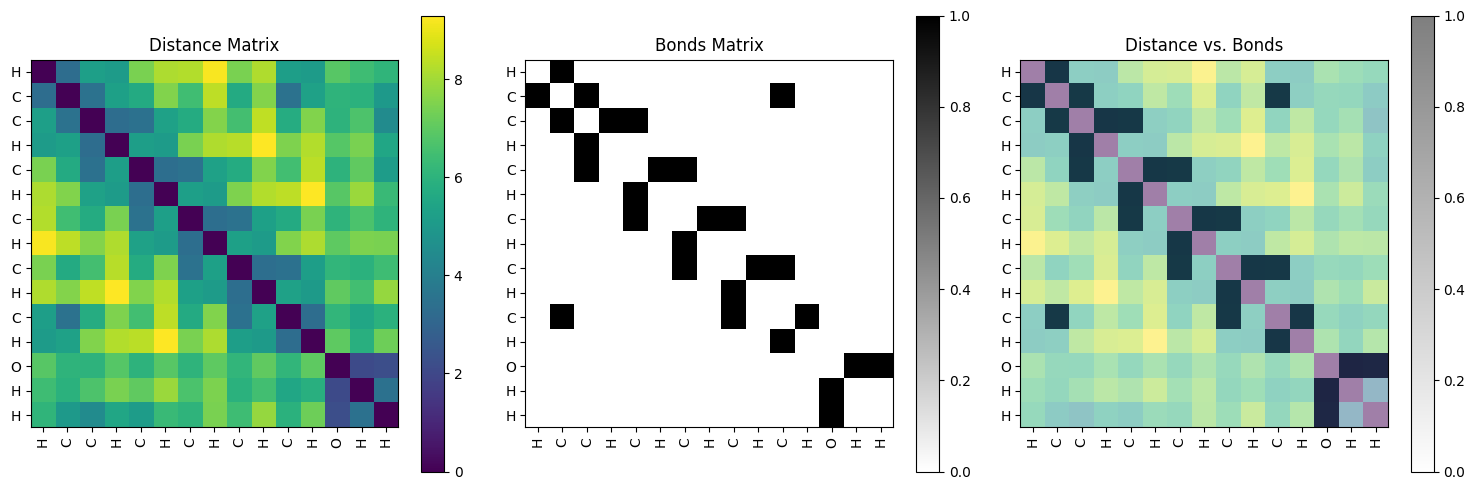

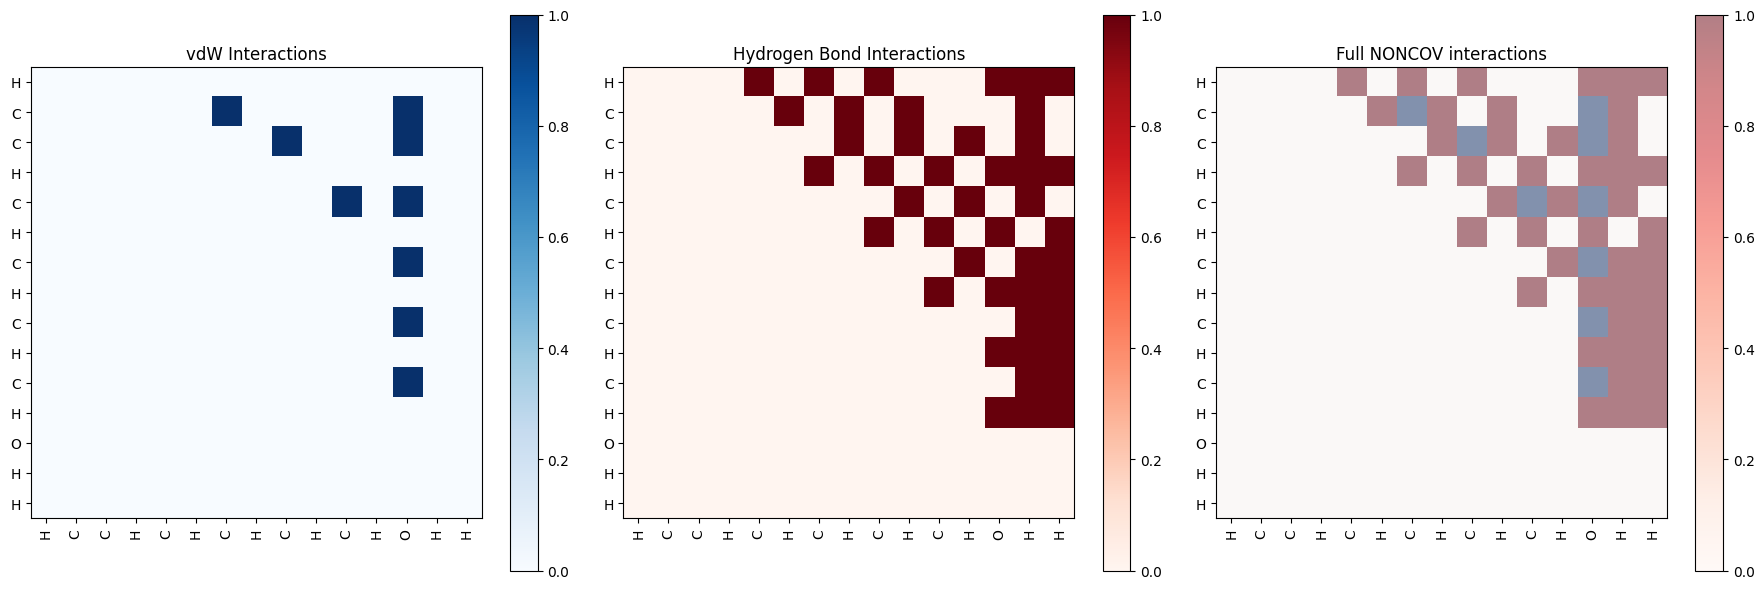

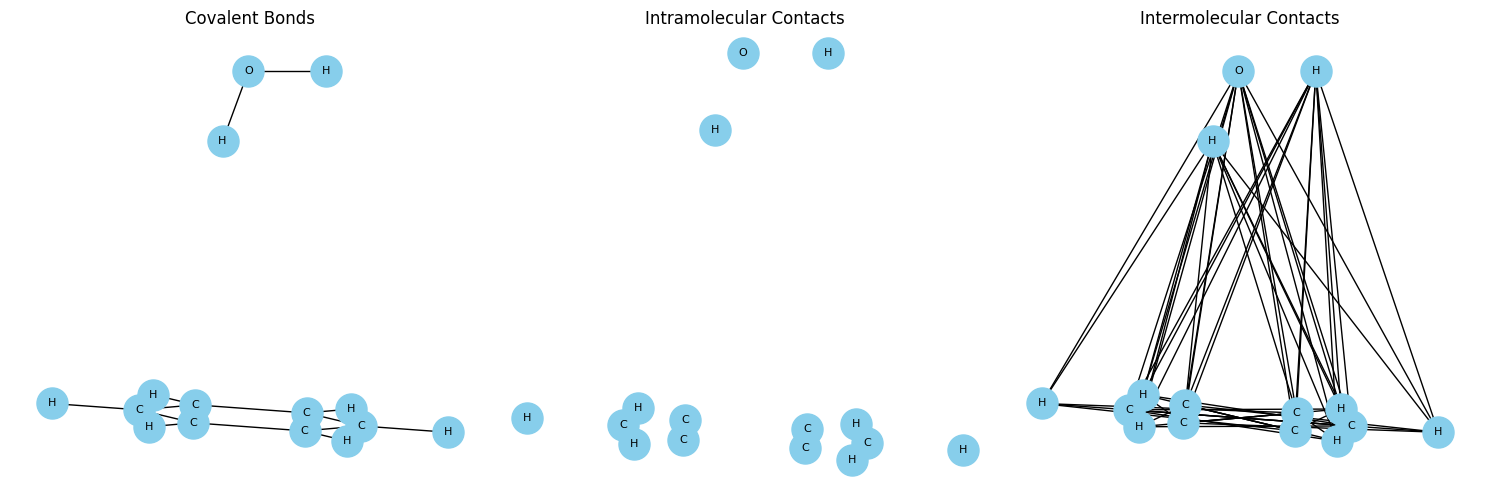

In [7]:
fragment1 =(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
fragment2 = (13, 14, 15)

mol_graph = MolecularGraph()

# Parse the XYZ file
atom_types, coordinates = mol_graph.parse_xyz(mol_dir)

# Calculate pairwise distances
distances = mol_graph.calculate_distances(coordinates)

# Detect covalent bonds
covalent_bonds = mol_graph.detect_bonds(atom_types, distances)

# Detect non-covalent interactions
noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)

# Build the molecular graph
#mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)

# Visualize the molecular graph
#mol_graph.draw()

# Plots 
mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

# Build different graphs
covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

# Draw subplots while preserving atom positions
mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)


threshold = 1.6